In [1]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns

In [40]:
df_dict = {
    'all': {},
    'CDS': {},
    'CAT': {}
}
df_dict['all']['X_train'] = pd.read_csv('train/X_train.csv')
df_dict['all']['y_train'] = pd.read_csv('train/y_train.csv')
df_dict['all']['X_test'] = pd.read_csv('test/X_test.csv')
df_dict['all']['y_test'] = pd.read_csv('test/y_test.csv')
df_dict['CDS']['X_train'] = df_dict['all']['X_train'].iloc[:,18:]
df_dict['CDS']['y_train'] = df_dict['all']['y_train']
df_dict['CDS']['X_test'] = df_dict['all']['X_test'].iloc[:,18:]
df_dict['CDS']['y_test'] = df_dict['all']['y_test']
df_dict['CAT']['X_train'] = pd.read_csv('train/X_train_cat.csv').iloc[:,18:]
df_dict['CAT']['y_train'] = pd.read_csv('train/y_train_cat.csv')
df_dict['CAT']['X_test'] = pd.read_csv('test/X_test_cat.csv').iloc[:,18:]
df_dict['CAT']['y_test'] = pd.read_csv('test/y_test_cat.csv')

In [67]:
class SVMResults:
    def __init__(self, clf, y_pred, f1, train_f1, acc_anxiety, acc_depression, model_name, rows, X_test, y_test, best_hp, param_grid):
        self.clf = clf
        self.y_pred = y_pred
        self.f1 = f1
        self.train_f1 = train_f1
        self.acc_anxiety = acc_anxiety
        self.acc_depression = acc_depression
        self.name = model_name
        self.rows = rows
        self.X_test = X_test
        self.y_test = y_test
        self.best_hp = best_hp
        self.param_grid = param_grid

    param_grid = {
        'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'estimator__kernel': ['poly', 'rbf', 'sigmoid'],
        'estimator__gamma': ['scale', 'auto']
    }
    
    def build_model(X_train, y_train, X_test, y_test, param_grid, model_name, use_sample_weight=False):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
                #Create a svm Classifier
        anxiety_counts = y_train['group_anxiety'].value_counts()
        depression_counts = y_train['group_depression'].value_counts()
        # Total number of samples
        n_samples = len(y_train)

        # Anxiety
        anxiety_weight_0 = n_samples / (2 * anxiety_counts[0])
        anxiety_weight_1 = n_samples / (2 * anxiety_counts[1])

        # Depression
        depression_weight_0 = n_samples / (2 * depression_counts[0])
        depression_weight_1 = n_samples / (2 * depression_counts[1])
        
        # Initialize
        sample_weight = np.ones(n_samples)

        # For each sample, multiply the weights
        for i in range(n_samples):
            anxiety_label = y_train.iloc[i]['group_anxiety']
            depression_label = y_train.iloc[i]['group_depression']
            
            # Get corresponding weights
            a_weight = anxiety_weight_0 if anxiety_label == 0 else anxiety_weight_1
            d_weight = depression_weight_0 if depression_label == 0 else depression_weight_1
            # Multiply both
            sample_weight[i] = a_weight * d_weight
        
        # Create a svm Classifier
        svc = svm.SVC(verbose= False, probability = True, random_state=26)
        multi_svc = MultiOutputClassifier(svc)
        gs = GridSearchCV(multi_svc, param_grid, cv=3, n_jobs=-1, scoring='f1_macro')
        
        if use_sample_weight:
            gs.fit(X_train, y_train, sample_weight=sample_weight)
        else:
            gs.fit(X_train, y_train)
        #Train the model using the training sets

        #Predict the response for test dataset
        y_pred = gs.predict(X_test)
        pickle.dump(gs, open(f'models/{model_name}.pkl', 'wb'))
        f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
        train_f1 = round(f1_score(y_train, gs.predict(X_train), average='macro'), 3)

        acc_anxiety = round(accuracy_score(y_test.iloc[:,0], y_pred[:,0]), 3)
        acc_depression = round(accuracy_score(y_test.iloc[:,1], y_pred[:,1]), 3)
        return SVMResults(gs, y_pred, f1, train_f1, acc_anxiety, acc_depression, 
                          model_name, X_test.shape[0], X_test, y_test, gs.best_params_, param_grid)
        
    def plot_training_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_test, self.y_test, cv=5, n_jobs=-1)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.figure()
        plt.title(f"Learning Curve for {self.name}")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - np.std(train_scores, axis=1),
                         train_scores_mean + np.std(train_scores, axis=1), alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - np.std(test_scores, axis=1),
                         test_scores_mean + np.std(test_scores, axis=1), alpha=0.1,
                         color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()

In [68]:
# Store results
all_results = {}

for subset_name, data in df_dict.items():
    print(f"Training model for subset: {subset_name}")
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    SVM_result = SVMResults.build_model(X_train, y_train, X_test, y_test, SVMResults.param_grid, model_name=f'{subset_name}_svm')

    # Store results by subset name
    all_results[subset_name] = SVM_result

for subset, result in all_results.items():
    print(f"Results for {subset}: F1 = {result.f1}, Anxiety Acc = {result.acc_anxiety}, Depression Acc = {result.acc_depression}")

Training model for subset: all
Training model for subset: CDS
Training model for subset: CAT
Results for all: F1 = 0.759, Anxiety Acc = 0.599, Depression Acc = 0.625
Results for CDS: F1 = 0.759, Anxiety Acc = 0.599, Depression Acc = 0.625
Results for CAT: F1 = 0.759, Anxiety Acc = 0.599, Depression Acc = 0.625


In [73]:
for subset, result in all_results.items():
    print(f"Results for {subset}:")
    print(classification_report(result.y_test, result.y_pred, zero_division=0, target_names=y_train.columns.values))
    test_accuracy = accuracy_score(result.y_test, result.y_pred)
    print(f"Train F1 score: {result.train_f1:.4f}")
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy anxiety: {result.acc_anxiety:.4f}")
    print(f"Accuracy depression: {result.acc_depression:.4f}")
    print('\n')

Results for all:
                  precision    recall  f1-score   support

   group_anxiety       0.60      1.00      0.75       278
group_depression       0.62      1.00      0.77       290

       micro avg       0.61      1.00      0.76       568
       macro avg       0.61      1.00      0.76       568
    weighted avg       0.61      1.00      0.76       568
     samples avg       0.61      1.00      0.74       568

Train F1 score: 0.7600
Test Set Accuracy: 0.2241
Accuracy anxiety: 0.5990
Accuracy depression: 0.6250


Results for CDS:
                  precision    recall  f1-score   support

   group_anxiety       0.60      1.00      0.75       278
group_depression       0.62      1.00      0.77       290

       micro avg       0.61      1.00      0.76       568
       macro avg       0.61      1.00      0.76       568
    weighted avg       0.61      1.00      0.76       568
     samples avg       0.61      1.00      0.74       568

Train F1 score: 0.7600
Test Set Accuracy: 0.

In [70]:
# Plot confusion matrices for all subsets and both labels
def plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression']):
    num_subsets = len(all_results)
    fig, axes = plt.subplots(num_subsets, 2, figsize=(10, 4 * num_subsets))
    
    if num_subsets == 1:
        axes = [axes]  # Ensure iterable shape consistency if only 1 subset
    
    for row_idx, (subset, result) in enumerate(all_results.items()):
        
        for col_idx, label in enumerate(label_names):
            ax = axes[row_idx][col_idx] if num_subsets > 1 else axes[0][col_idx]

            # Confusion Matrix
            cm = confusion_matrix(result.y_test.iloc[:, col_idx], result.y_pred[:, col_idx])
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                        xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
            
            ax.set_title(f"{subset} - {label}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

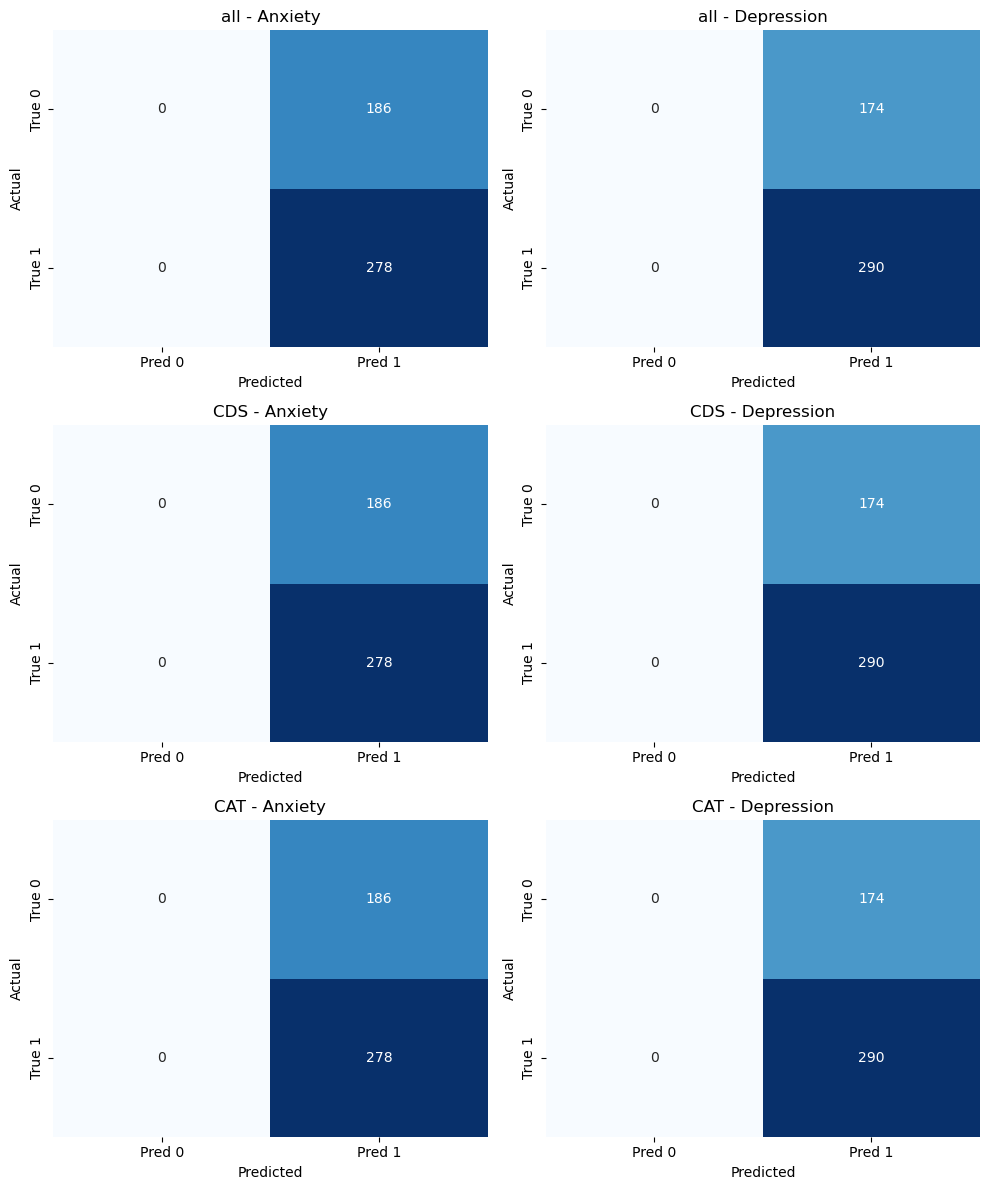

In [71]:
plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression'])

/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future vers

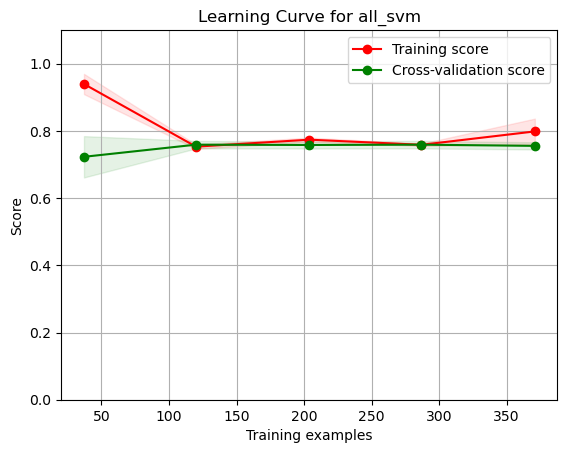

/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

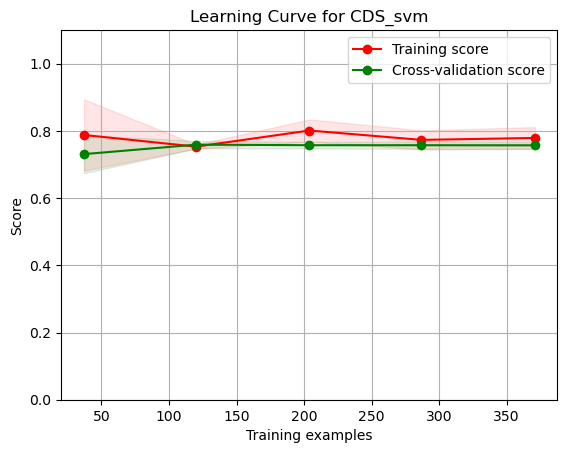

/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

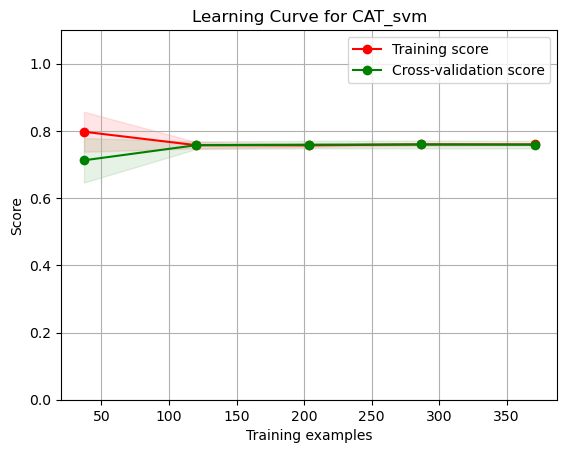

In [72]:
for subset, result in all_results.items():
    result.plot_training_curve()

In [45]:
for subset, result in all_results.items():
    print(f"Subset: {subset}")
    print(f"Best Hyperparameters: {result.clf.best_params_}")
    print("\n")

Subset: all
Best Hyperparameters: {'estimator__C': 0.0001, 'estimator__gamma': 'scale', 'estimator__kernel': 'poly'}


Subset: CDS
Best Hyperparameters: {'estimator__C': 0.0001, 'estimator__gamma': 'scale', 'estimator__kernel': 'poly'}


Subset: CAT
Best Hyperparameters: {'estimator__C': 0.0001, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}




In [46]:
# Function to plot ROC curves per label per subset
def plot_roc_curves(all_results, label_names=['Anxiety', 'Depression']):
    plt.figure(figsize=(12, 6))

    # Separate plots for Anxiety and Depression
    for i, label in enumerate(label_names):
        plt.subplot(1, 2, i+1)
        plt.title(f'ROC Curve - {label}')
        
        for subset, result in all_results.items():
            # Predict probabilities again (y_pred_proba)
            y_proba = result.clf.predict(result.X_test)  # result.X_test needs to be saved in NNResults
            
            if isinstance(y_proba, list):
                y_proba = y_proba[0]  # For Keras predict returning list

            fpr, tpr, _ = roc_curve(result.y_test.iloc[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{subset} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

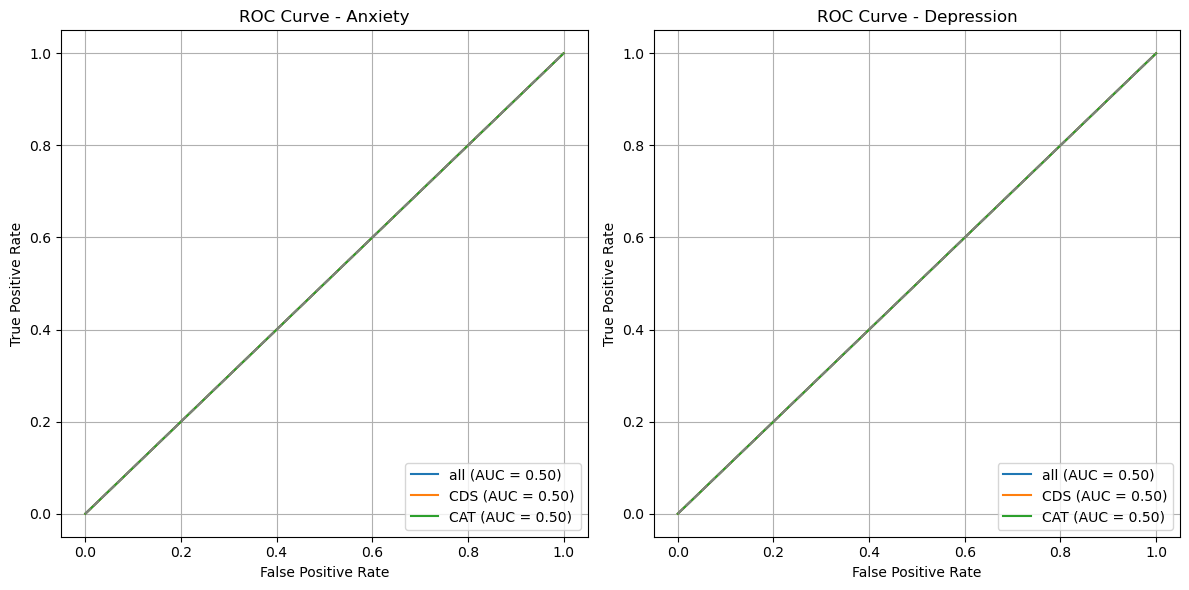

In [47]:
plot_roc_curves(all_results, label_names=['Anxiety', 'Depression'])

In [48]:
with_sample_weight_svm = SVMResults.build_model(
    df_dict['all']['X_train'], 
    df_dict['all']['y_train'], 
    df_dict['all']['X_test'], 
    df_dict['all']['y_test'], 
    SVMResults.param_grid, 
    model_name='with_sample_weight_svm', 
    use_sample_weight=True
)

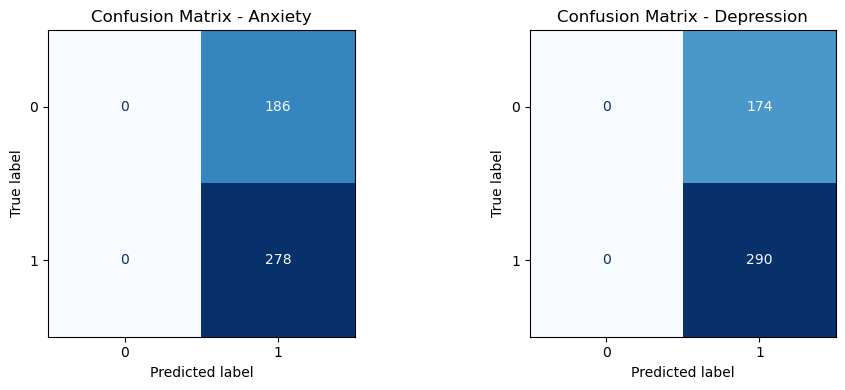

In [54]:
# Generate the confusion matrices
matrices = multilabel_confusion_matrix(with_sample_weight_svm.y_test, with_sample_weight_svm.y_pred)

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


# Plot Anxiety confusion matrix
ConfusionMatrixDisplay(matrices[0]).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix - Anxiety')

# Plot Depression confusion matrix
ConfusionMatrixDisplay(matrices[1]).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix - Depression')

# Adjust layout
plt.tight_layout()
plt.show()